<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Bet%20Sizing/Bet_sizing_9_(new).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

META-LABELING AND BET SIZING

This notebook is based on the book *Advances in Financial Machine Learning* by Lopez De Prado. (Chapter 3 and Chapter 10)

# IMPORT LIB

In [0]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [0]:
# sklearn

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

In [0]:
!pip install -q ta
import ta

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Big thanks to mlfinlab!

!pip install mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util, sampling, cross_validation

# 1. Bet sizing  applying meta-labeling

We fit a
classifier, such as an SVC or RF, to determine the probability of misclassification, and
use that probability to derive the bet size.

### WHY do we use meta-labeling for sizing the bet?

Advantages
1. The ML algorithm that decides the bet sizes is independent of the primary model, allowing for the incorporation of features predictive of false positives (meta-labeling - see below). 

2. The predicted probability can be directly translated into bet size.

### What is meta labeling?

Suppose that you have a model for setting the side of the bet (long or short). You just need to learn the size of that bet, which includes the possibility of no bet at all (zero size). This is a situation that practitioners face regularly. We often know whether we want to buy or sell a product, and the only remaining question is **how much money we should risk in such a bet**. We do not want the ML algorithm to learn the side, just
to tell us what is the **appropriate size**. We want to build a **secondary ML model** that learns how to use a primary exogenous model.

Binary classification problems present a trade-off between type-I errors (false positives) and type-II errors (false negatives). In general, increasing the true positive rate of a binary classifier will tend to increase its false positive rate. The receiver operating characteristic (ROC) curve of a binary classifier measures the cost of increasing the true positive rate, in terms of accepting higher false positive rates.

Meta-labeling is particularly helpful when you want to achieve higher F1-scores. First, we build a model that achieves high recall, even if the precision is not particularly high. Second, we correct for the low precision by applying meta-labeling to the positives predicted by the primary model.

Meta-labeling will increase your F1-score by filtering out the false positives, where the majority of positives have already been identified by the primary model. Stated differently, the role of the secondary ML algorithm is to determine whether a positive from the primary (exogenous) model is true or false. It is not its purpose to come up with a betting opportunity. Its purpose is to determine whether we should act or pass
on the opportunity that has been presented.



Advantages of meta-labeling

First, ML algorithms are often criticized as black boxes.
Meta-labeling allows you to build an ML system on top of a white box (like a fundamental model founded on economic theory). This ability to transform a fundamental model into an ML model should make meta-labeling particularly useful to “quantamental” firms. 

Second, the effects of overfitting are limited when you apply meta labeling,
because ML will not decide the side of your bet, only the size. 

Third, by decoupling the side prediction from the size prediction, meta-labeling enables sophisticated strategy structures. For instance, consider that the features driving a rally may differ from the features driving a sell-off. In that case, you may want to develop an
ML strategy exclusively for long positions, based on the buy recommendations of a primary model, and an ML strategy exclusively for short positions, based on the sell recommendations of an entirely different primary model. 

Fourth, achieving high accuracy on small bets and low accuracy on large bets will ruin you. As important as identifying good opportunities is to size them properly, so it makes sense to develop an ML algorithm solely focused on getting that critical decision (sizing) right. - Bet Sizing

3 steps


1. Use your forecasts from the primary model, and generate meta-labels. Remember, horizontal barriers do not need to be symmetric in this case.

2. Fit your model again on the same training set, but this time using the meta-labels you just generated.

3. Combine the “sides” from the first ML model with the “sizes” from the second ML model. I.e. if your primary model predicts a 3 and your secondary model says you have a high probability of the primary model being correct, is your final prediction a 3, else not 3.

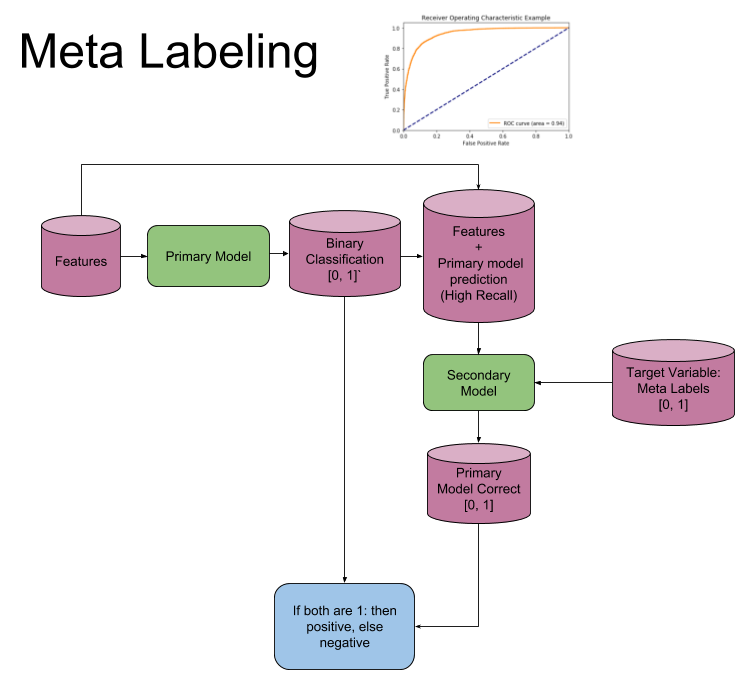

In [8]:
from IPython.core.display import Image
Image(filename='/content/drive/My Drive/Colab Notebooks/images/meta-labeling.png')

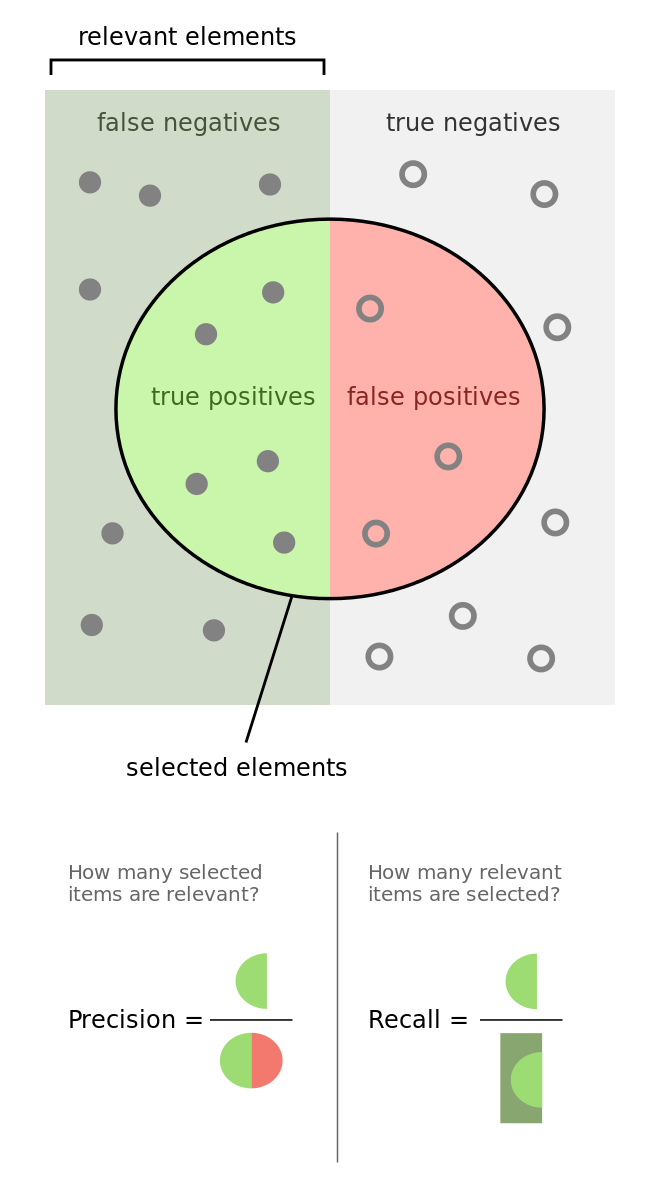

In [9]:
Image(filename='/content/drive/My Drive/Colab Notebooks/images/f1.png')

F-score (F1 score) is the harmonic mean of precision and recall

### Steps 


https://hudsonthames.org/does-meta-labeling-add-to-signal-efficacy-triple-barrier-method/

1. Compute long short signals for the strategy. For instance, in the mean-reverting strategy, generate a long signal when the close price is below the lower Bollinger band and create a sell signal if the close price is higher than the upper Bollinger band. We call this the “Primary model”.

2. Get time stamps of the events using CUSUM (or cumulative sum control chart) filter and point estimate of the volatility. See section 4.2.
Determine events when one of the three exit points (profit taking, stop-loss and vertical barrier) occur. Advances in Financial Machine Learning discusses this in Chapter 3. The result of this step is a trade decision – long or short, or 1 or -1.

3. Determine the bet size. The prior step tell us the direction of the trade. This step says if we should trade or not – a one or zero decision.
Tune the hyper-parameters (max_depth and n_estimators) of Random Forest using grid search and cross-validation. We keep the random state constant for reproducibility of the results.

4. Train a machine-learning algorithm (we use Random Forest for illustration) with new features like one to five day serial correlations, one to five-day returns, 50-day volatility, and 14-day RSI. We iterate over this step number of times until we see in-sample results that are acceptable. In other words, we only exit this step when we consider the model to be ready and there is no turning back.

5. Evaluate the performance of in sample and out-of-sample or this meta-model model.
Evaluate the performance of the “Primary model”
Compare the performance of the meta-model and the primary model

## Read in data - dollar bars

E-mini S&P Future tick data

In [10]:
# make dollar bars from tick data
threshold = 200_000
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=threshold)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [11]:
dollar_bars.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:33:08,14,50.79,50.8226,50.7100,50.8200,4136,2598,14,210018.6000
2009-09-28 09:40:44,32,50.81,50.8500,50.7833,50.7833,4008,966,18,203668.6338
2009-09-28 09:44:24,45,50.80,50.9300,50.8000,50.9300,4000,3700,13,203577.0000
2009-09-28 09:46:34,60,51.00,51.0700,51.0000,51.0700,4800,3100,15,245058.0000
2009-09-28 09:46:35,63,51.07,51.0700,51.0700,51.0700,6200,6200,3,316634.0000


In [12]:
len(dollar_bars)

217520

In [0]:
close = dollar_bars.close

Why do we use dollar bars?

See Chapter 2

## 1. Train a primary model (which decides 'sides') 

### First Option
- Based on the simple moving average cross-over strategy.

In [0]:

fast_window = 20
slow_window = 50

df = pd.DataFrame()
df['fast_mavg'] = close.rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = close.rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

df['side'] = df['side'].shift(1)

sma_crossover = df['side']

In [0]:
# side = sma_crossover
# side.value_counts()

### Second Option
- Based on the mean-reverting Bollinger band strategy.

In [0]:
n=60

df = pd.DataFrame()

df['lower'] = ta.volatility.bollinger_lband(close,n)
df['upper'] = ta.volatility.bollinger_hband(close,n)
df['close'] = close
df['side'] = np.nan

long_signals = (df['close'] <= df['lower']) 
short_signals = (df['close'] >= df['upper']) 

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

bbsignal = df['side']

In [0]:
f,ax=plt.subplots(figsize=(10,6))
# make a plot
ax.plot(df.iloc[-1000:,:3])
ax.set_ylabel("price")
ax.legend(labels = df[:3].columns)
ax2=ax.twinx()
ax2.plot(df.side.iloc[-1000:],color="blue",marker="*")
ax2.set_ylabel("side")
plt.show()


In [30]:
side = bbsignal
side.value_counts()

-1.0    16261
 1.0    15617
Name: side, dtype: int64

### Third Option
- Based on Logistic Regression

## 2. Generate labels (from a primary model)

Get time stamps of the events using CUSUM filter and point estimate of the volatility.

In [0]:
# form a tripple-barrier
pt_sl = [1,2]

target = util.get_daily_vol(close,lookback=100)

h = target.mean()*0.5
t_events = filters.cusum_filter(close, h) # using symmetric cusum filter, get t_events

vertical_barrier_times = labeling.add_vertical_barrier(t_events, close, num_days=1)

In [33]:
events.dropna()

,t1,trgt,side,pt,sl
2009-09-30 09:46:02,2009-09-30 13:04:44,0.005880,1.0,1,2
2009-09-30 09:51:41,2009-09-30 12:53:33,0.006470,1.0,1,2
2009-09-30 09:57:13,2009-09-30 12:53:33,0.007836,1.0,1,2
2009-10-01 10:00:32,2009-10-01 13:20:09,0.006084,1.0,1,2
2009-10-01 13:20:09,2009-10-02 09:29:18,0.006694,1.0,1,2
...,...,...,...,...,...
2019-06-12 10:31:07,2019-06-13 09:36:29,0.004624,1.0,1,2
2019-06-13 09:47:27,2019-06-13 11:09:28,0.003545,-1.0,1,2
2019-06-13 10:07:58,2019-06-14 10:08:37,0.003626,-1.0,1,2
2019-06-18 09:39:42,2019-06-19 09:42:00,0.004532,-1.0,1,2


In [34]:
# events
min_ret = 0.003

events = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=3, 
                             vertical_barrier_times = vertical_barrier_times ,side_prediction = side)

# label (bin) - binary classification from the primary model

bin = labeling.get_bins(events, close)

2020-02-01 13:18:29.781509 100.0% apply_pt_sl_on_t1 done after 0.58 minutes. Remaining 0.0 minutes.


In [0]:
bin.dropna(inplace=True)

In [37]:
bin

,ret,trgt,bin,side
2009-09-30 09:46:02,0.006062,0.005880,1,1.0
2009-09-30 09:51:41,0.006671,0.006470,1,1.0
2009-09-30 09:57:13,0.009245,0.007836,1,1.0
2009-10-01 10:00:32,-0.013202,0.006084,0,1.0
2009-10-01 16:16:36,-0.019210,0.007672,0,1.0
...,...,...,...,...
2019-06-12 10:31:07,0.005050,0.004624,1,1.0
2019-06-13 09:47:27,0.003839,0.003545,1,-1.0
2019-06-13 10:07:58,0.002393,0.003626,0,-1.0
2019-06-18 09:39:42,-0.003816,0.004532,0,-1.0


In [38]:
bin.side.value_counts()

 1.0    1338
-1.0    1008
Name: side, dtype: int64

In [39]:
bin.bin.value_counts()

0    1361
1     985
Name: bin, dtype: int64

In [40]:
primary_forecast = pd.DataFrame(bin['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']

print(classification_report(actual, pred))

print("Accuracy = ", accuracy_score(actual,pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(actual, pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1361
           1       0.42      1.00      0.59       985

    accuracy                           0.42      2346
   macro avg       0.21      0.50      0.30      2346
weighted avg       0.18      0.42      0.25      2346

Accuracy =  0.4198635976129582

Confusion Matrix


## 3. Features



Features - Kara et al. (2011)


- Simple 10-day moving average
- Weighted 10-day moving average
- Momentum
- Stochastic K%
- Stochastic D%
- RSI (Relative Strength Index)
- MACD (moving average convergence divergence)
- Larry William’s R% 
- A/D (Accumulation/Distribution) Oscillator
- CCI (Commodity Channel Index)

### from TA

https://github.com/bukosabino/ta

In [41]:
bars = dollar_bars.iloc[:,1:6]
bars = bars.loc[bin.index,:]
bars.head()

,open,high,low,close,volume
2009-09-30 09:46:02,51.25,51.2500,51.1400,51.1400,4063
2009-09-30 09:51:41,51.17,51.2000,50.9427,50.9700,4048
2009-09-30 09:57:13,51.02,51.0652,50.8400,50.8400,4077
2009-10-01 10:00:32,50.56,50.7500,50.5500,50.7500,4082
2009-10-01 16:16:36,49.87,50.3166,49.7800,50.3166,112375


Volume
- Accumulation/Distribution Index (ADI)
-On-Balance Volume (OBV)
-Chaikin Money Flow (CMF)
-Force Index (FI)
-Ease of Movement (EoM, EMV)
-Volume-price Trend (VPT)
-Negative Volume Index (NVI)

Volatility
- Average True Range (ATR)
- Bollinger Bands (BB)
- Keltner Channel (KC)
- Donchian Channel (DC)

Trend
- Moving Average Convergence Divergence (MACD)
- Average Directional Movement Index (ADX)
- Vortex Indicator (VI)
- Trix (TRIX)
- Mass Index (MI)
- Commodity Channel Index (CCI)
- Detrended Price Oscillator (DPO)
- KST Oscillator (KST)
- Ichimoku Kinkō Hyō (Ichimoku)
- Parabolic Stop And Reverse (Parabolic SAR)

Momentum
- Money Flow Index (MFI)
- Relative Strength Index (RSI)
- True strength index (TSI)
- Ultimate Oscillator (UO)
- Stochastic Oscillator (SR)
- Williams %R (WR)
- Awesome Oscillator (AO)
- Kaufman's Adaptive Moving Average (KAMA)
- Rate of Change (ROC)

Others
- Daily Return (DR)
- Daily Log Return (DLR)
- Cumulative Return (CR)

In [0]:
ta_features = ta.add_all_ta_features(bars,'open','high','low','close','volume')

In [43]:
#look-ahead bias
ta_features = ta_features.shift(1)

ta_features.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
2009-09-30 09:46:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-30 09:51:41,51.25,51.2500,51.1400,51.14,4063.0,-4063.000000,4063.0,-1.000000,NaN,NaN,NaN,-1444.605825,1000.000000,0.0,51.140000,51.140000,51.140000,0.000000,0.0,0.0,51.176667,51.176667,51.066667,0.0,0.0,51.14,51.14,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,28.233684,-355.705851,-355.705851,0.000000,51.19500,51.19500,79.062847,78.346967,4.0,4.0,0.0,51.1400,NaN,NaN,0.0,0.0,100.0,NaN,NaN,NaN,0.000000,0.000000,-100.000000,0.0,NaN,NaN,-35.570585,NaN,0.000000
2009-09-30 09:57:13,51.17,51.2000,50.9427,50.97,4048.0,-7251.999611,15.0,-0.894094,NaN,-785.947258,-785.947258,-1458.689267,996.675792,0.0,51.055000,51.225000,50.885000,0.340000,0.0,0.0,51.107117,51.107117,50.923467,0.0,0.0,50.97,51.14,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-66.666667,28.318684,-356.776735,-356.241293,-0.535442,51.09635,51.09635,79.062847,78.346967,4.0,8.0,-4.0,50.9700,NaN,NaN,0.0,0.0,0.0,NaN,-100.0,NaN,8.883827,4.441913,-91.116173,0.0,NaN,NaN,-0.332421,-0.332975,-0.332421
2009-10-01 10:00:32,51.02,51.0652,50.8400,50.84,4077.0,-11328.999611,-4062.0,-0.929521,NaN,-655.935737,-720.941497,-23.854864,996.675792,0.0,50.983333,51.229007,50.737660,0.491347,0.0,0.0,51.043100,51.043100,50.845600,0.0,1.0,50.84,51.14,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-95.857250,28.390350,-357.679637,-356.720741,-0.958896,51.04500,51.04500,79.062847,78.346967,4.0,12.0,-8.0,51.2500,NaN,51.2500,0.0,1.0,0.0,NaN,-100.0,NaN,0.000000,2.961276,-100.000000,0.0,NaN,NaN,-0.255052,-0.255378,-0.586625
2009-10-01 16:16:36,50.56,50.7500,50.5500,50.75,4082.0,-7246.999611,-8144.0,-0.445421,NaN,-1482.606565,-974.829853,-17.624670,996.675792,0.0,50.925000,51.218428,50.631572,0.586856,0.0,0.0,50.953158,50.953158,50.755033,0.0,1.0,50.75,51.14,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-116.838972,28.448684,-358.414557,-357.144195,-1.270362,50.90000,50.90000,79.062847,78.346967,4.0,16.0,-12.0,51.2418,NaN,51.2418,0.0,0.0,0.0,NaN,-100.0,NaN,28.571429,12.485085,-71.428571,0.0,NaN,NaN,-0.177026,-0.177183,-0.762612


In [44]:
ta_features.columns

Index(['open', 'high', 'low', 'close', 'volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dchi', 'volatility_dcli', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_ema_fast',
       'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
   

In [0]:
ta_features_3 = ta_features.loc[:, ['volume_adi', 'volatility_atr', 'trend_macd',
                    'trend_cci', 'momentum_rsi', 'momentum_stoch', 'momentum_kama']]

In [46]:
ta_features_3 = ta_features_3.dropna(axis=1,how='any',thresh=len(ta_features)-20)
ta_features_3 = ta_features_3.dropna()
ta_features_3

,volume_adi,volatility_atr,trend_cci,momentum_rsi,momentum_stoch,momentum_kama
2009-10-05 10:08:24,109120.034278,0.420510,-5.033822,40.135779,44.131068,50.099100
2009-10-05 10:41:50,105038.034278,0.407459,-12.812807,36.945660,34.466019,50.082564
2009-10-06 09:34:36,112387.210748,0.386613,-6.360426,41.660925,43.592233,50.082834
2009-10-06 09:43:53,115333.960748,0.440152,86.385254,57.920118,87.378641,50.089605
2009-10-06 10:47:27,119089.188630,0.414837,91.831403,60.298063,96.116505,50.106344
...,...,...,...,...,...,...
2019-06-12 10:31:07,-29119.309037,0.658923,145.765038,63.601871,100.000000,113.318100
2019-06-13 09:47:27,-31133.309037,0.648761,118.579833,59.677728,91.305772,113.471809
2019-06-13 10:07:58,-28870.309037,0.656615,129.107862,62.895196,100.000000,113.725259
2019-06-18 09:39:42,-28870.309037,0.626953,101.904939,60.329118,93.673111,113.870172


### Other features

from hudson-thames

In [0]:
raw_data = pd.DataFrame(bars.close)

log_ret = np.log(raw_data['close']).diff()

raw_data['sma10'] = raw_data['close'].rolling(window = 10).mean()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)

'''# Volatility
raw_data['volatility_50'] = log_ret.rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = log_ret.rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = log_ret.rolling(window=15, min_periods=15, center=False).std()'''

# Serial Correlation
window_autocorr = 50

raw_data['autocorr_1'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)

# Remove look ahead bias
raw_data = raw_data.shift(1)

In [0]:
raw_X = raw_data.join(ta_features_3)
raw_X = raw_X.iloc[:,1:]
raw_X.dropna(inplace=True)

In [49]:
raw_X

,sma10,mom1,mom2,mom3,autocorr_1,autocorr_2,autocorr_3,volume_adi,volatility_atr,trend_cci,momentum_rsi,momentum_stoch,momentum_kama
2009-11-03 09:34:03,49.62249,0.012841,0.013461,0.008524,-0.082592,0.079436,0.250410,132838.403091,0.337979,-41.873496,44.191955,58.289616,50.156455
2009-11-04 10:00:01,49.59649,-0.009056,0.003669,0.004283,-0.111291,0.074601,0.253757,130976.713436,0.365181,-96.419640,39.898028,20.817720,50.144877
2009-11-04 15:41:23,49.63549,0.022543,0.013282,0.026294,-0.151382,0.140220,0.252032,135208.713436,0.439663,94.953706,52.228404,100.000000,50.148053
2009-11-04 15:50:50,49.61040,-0.008143,0.014216,0.005031,-0.186674,0.158134,0.215134,131041.713436,0.436697,30.599894,48.287735,69.852941,50.145915
2009-11-05 09:30:09,49.58740,-0.003805,-0.011917,0.010357,-0.237581,0.134555,0.217318,127415.580103,0.413027,-3.367553,46.535462,55.882353,50.142075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-12 10:31:07,113.00729,0.004899,0.009551,0.014573,-0.103322,-0.071258,0.118662,-29119.309037,0.658923,145.765038,63.601871,100.000000,113.318100
2019-06-13 09:47:27,113.26256,-0.004852,0.000024,0.004653,-0.115929,-0.072053,0.101037,-31133.309037,0.648761,118.579833,59.677728,91.305772,113.471809
2019-06-13 10:07:58,113.53356,0.006362,0.001480,0.006386,-0.108467,-0.091959,0.119484,-28870.309037,0.656615,129.107862,62.895196,100.000000,113.725259
2019-06-18 09:39:42,113.79808,-0.003129,0.003213,-0.001654,-0.060287,-0.101669,0.077475,-28870.309037,0.626953,101.904939,60.329118,93.673111,113.870172


### PCA

In [50]:
# Feature decomposition PCA

n=5
pca = PCA(n)
pca.fit(raw_X)
pcaX = pca.transform(raw_X)

X = pd.DataFrame(index=raw_X.index)
for i in range(n):
  a = pd.Series(data=pcaX[:,i],index=raw_X.index,name=i)
  X = X.join(a)
'''

# No PCA
X = raw_X.copy()'''

'\n\n# No PCA\nX = raw_X.copy()'

### Including side from first model

In [0]:
X['side'] = side

### Fracdiff

In [0]:
#fd = features.fracdiff.frac_diff(bars.close.to_frame(),0.2)

In [0]:
#X['fd'] = fd

### X

In [0]:
X.dropna(inplace=True)

In [55]:
X.head()

,0,1,2,3,4,side
2009-11-03 09:34:03,-49519.770518,48.263123,48.574760,16.504829,1.730497,-1.0
2009-11-04 10:00:01,-51381.464310,111.664439,46.245076,-2.298306,-0.198630,-1.0
2009-11-04 15:41:23,-47149.450858,-94.729148,50.258616,14.059507,6.855062,1.0
2009-11-04 15:50:50,-51316.455429,-24.445430,48.893908,5.204780,4.095072,1.0
2009-11-05 09:30:09,-54942.591121,11.938623,48.491098,2.364450,2.390860,1.0


In [56]:
len(X)

2295

## 4. Fit a second ML model

In [0]:
tmp_data = X.copy()
tmp_data = tmp_data.join(bin.bin)
tmp_data.dropna(inplace=True)

X = tmp_data.iloc[:,:-1]
y = tmp_data[['bin']]

In [0]:
t1 = events['t1'].loc[X.index]
idx = events.loc[X.index].index

In [59]:
X

,0,1,2,3,4,side
2009-11-03 09:34:03,-49519.770518,48.263123,48.574760,16.504829,1.730497,-1.0
2009-11-04 10:00:01,-51381.464310,111.664439,46.245076,-2.298306,-0.198630,-1.0
2009-11-04 15:41:23,-47149.450858,-94.729148,50.258616,14.059507,6.855062,1.0
2009-11-04 15:50:50,-51316.455429,-24.445430,48.893908,5.204780,4.095072,1.0
2009-11-05 09:30:09,-54942.591121,11.938623,48.491098,2.364450,2.390860,1.0
...,...,...,...,...,...,...
2019-06-12 10:31:07,-211477.478375,-155.626784,-22.194486,4.910075,2.676496,1.0
2019-06-13 09:47:27,-213491.480273,-126.979471,-22.585394,4.969214,3.956148,-1.0
2019-06-13 10:07:58,-211228.479478,-139.766754,-22.679684,10.085257,2.052142,-1.0
2019-06-18 09:39:42,-211228.481333,-111.821503,-23.137937,12.440555,2.104173,-1.0


In [0]:
#skf = cross_validation.PurgedKFold(n_splits=5,samples_info_sets= t1, pct_embargo = 0.01)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

### 1st - Random Forest

In [62]:
avgU = sampling.get_av_uniqueness_from_triple_barrier(t1.to_frame(), bars.close, 3).mean()
max_samples = avgU[0]
max_samples

2020-02-01 13:30:56.288274 100.0% num_concurrent_events done after 0.03 minutes. Remaining 0.0 minutes.
2020-02-01 13:30:57.472187 100.0% _get_average_uniqueness done after 0.02 minutes. Remaining 0.0 minutes.


0.5885033374242572

In [63]:
clf0 = RandomForestClassifier(n_estimators=1,criterion='entropy',bootstrap = False, class_weight='balanced_subsample')
clf1 = BaggingClassifier(base_estimator=clf0, max_samples=max_samples, max_features=1, n_estimators=1000)
clf1.fit(X_train, y_train.values.ravel())

#this is the method in the book

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced_subsample',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_frac

In [64]:
'''parameters = {'max_depth':[2, 3, 5, 7],
              'n_estimators':[100, 512, 1000]}
#hyper-parameter tuning

rf = RandomForestClassifier(criterion='entropy',max_samples=max_samples, class_weight='balanced_subsample')
clf = GridSearchCV(rf, parameters, cv=3, n_jobs=3)
clf.fit(X_train, y_train.values.ravel())'''

"parameters = {'max_depth':[2, 3, 5, 7],\n              'n_estimators':[100, 512, 1000]}\n#hyper-parameter tuning\n\nrf = RandomForestClassifier(criterion='entropy',max_samples=max_samples, class_weight='balanced_subsample')\nclf = GridSearchCV(rf, parameters, cv=3, n_jobs=3)\nclf.fit(X_train, y_train.values.ravel())"

In [0]:
#clf.best_estimator_

#### Train metrics - RF

In [0]:
y_pred_prob_0 = clf1.predict_proba(X_train)[:, 1]
y_pred_0 = clf1.predict(X_train)

In [0]:
rf_disp = plot_roc_curve(clf1, X_train, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

In [68]:
print(classification_report(y_train, y_pred_0))

print("Accuracy = ", accuracy_score(y_train, y_pred_0))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       841
           1       1.00      1.00      1.00       536

    accuracy                           1.00      1377
   macro avg       1.00      1.00      1.00      1377
weighted avg       1.00      1.00      1.00      1377

Accuracy =  0.9992737835875091

Confusion Matrix


#### Test metrics -RF

In [0]:
y_pred = clf1.predict(X_test)
y_pred_prob = clf1.predict_proba(X_test)[:, 1]

In [0]:
rf_disp = plot_roc_curve(clf1, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.show();

In [71]:
print(classification_report(y_test, y_pred))

print("Accuracy = ", accuracy_score(y_test, y_pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

              precision    recall  f1-score   support

           0       0.54      0.85      0.66       486
           1       0.51      0.17      0.26       432

    accuracy                           0.53       918
   macro avg       0.53      0.51      0.46       918
weighted avg       0.53      0.53      0.47       918

Accuracy =  0.5337690631808278

Confusion Matrix


### 2nd - SVC

이전 버전으로 보시오.

### 3rd - Boosting

이전 버전을 보시오.

## 5. Bet Sizing

When num_classes = 2,



$$ z=\frac{p[x=1]−\frac{1}{2}}{\sqrt{p[x=1](1−p[x=1])}} $$

$$ m=2Z[z]−1 $$

In [0]:
import scipy.stats as ss
p = np.linspace(0.001,1,1000,endpoint=False)
z = (p-0.5)/(np.sqrt(p*(1-p)))
Z_z = ss.norm.cdf(z)
m = (2 * Z_z -1) # np.sign(x)=1 always? increasing function
plt.plot(p,m)
plt.xlabel('p');
plt.ylabel('m:betting size');

In [0]:
from mlfinlab import bet_sizing as bs

In [0]:
p_rf = y_pred_prob # from RF (secondary model)
#p = y_pred_prob_svc # from SVM
#p_gbc = y_pred_prob_gbc # from Gradient Boosting

In [217]:
new_data = y_test.copy()
new_data['bin_pred_rf'] = y_pred
#new_data['bin_pred_gbc'] = y_pred_gbc
#new_data['p_gbc'] = p_gbc
new_data['p_rf'] = p_rf
new_data

,bin,bin_pred_rf,p_rf
2015-08-24 15:45:59,1,0,0.394455
2015-08-24 15:46:26,1,0,0.439455
2015-08-25 09:30:10,1,0,0.262455
2015-08-25 09:31:13,1,0,0.385455
2015-08-25 09:35:31,0,0,0.339455
...,...,...,...
2019-06-12 10:31:07,1,1,0.518953
2019-06-13 09:47:27,1,0,0.411191
2019-06-13 10:07:58,0,1,0.508191
2019-06-18 09:39:42,0,0,0.493191


In [0]:
# test에 맞추자
new_events = events.loc[new_data.index]
bs_df = pd.concat([new_events, new_data],axis=1)

In [219]:
bs_df

,t1,trgt,side,pt,sl,bin,bin_pred_rf,p_rf
2015-08-24 15:45:59,2015-08-24 15:49:57,0.007838,-1.0,1,2,1,0,0.394455
2015-08-24 15:46:26,2015-08-24 15:58:26,0.007942,-1.0,1,2,1,0,0.439455
2015-08-25 09:30:10,2015-08-25 13:26:25,0.014719,-1.0,1,2,1,0,0.262455
2015-08-25 09:31:13,2015-08-25 15:47:22,0.032742,-1.0,1,2,1,0,0.385455
2015-08-25 09:35:31,2015-08-26 09:36:28,0.041236,-1.0,1,2,0,0,0.339455
...,...,...,...,...,...,...,...,...
2019-06-12 10:31:07,2019-06-13 09:36:29,0.004624,1.0,1,2,1,1,0.518953
2019-06-13 09:47:27,2019-06-13 11:09:28,0.003545,-1.0,1,2,1,0,0.411191
2019-06-13 10:07:58,2019-06-14 10:08:37,0.003626,-1.0,1,2,0,1,0.508191
2019-06-18 09:39:42,2019-06-19 09:42:00,0.004532,-1.0,1,2,0,0,0.493191


In [220]:
m_prob_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_rf, num_classes=2, num_threads=3, pred=bs_df.side)
m_prob_rf

2015-08-24 15:45:59    0.170978
2015-08-24 15:46:26    0.097091
2015-08-25 09:30:10    0.410743
2015-08-25 09:31:13    0.186062
2015-08-25 09:35:31    0.265422
                         ...   
2019-06-12 10:31:07    0.030259
2019-06-13 09:47:27    0.143231
2019-06-13 10:07:58   -0.013071
2019-06-18 09:39:42    0.010867
2019-06-18 09:48:55    0.084587
Name: signal, Length: 918, dtype: float64

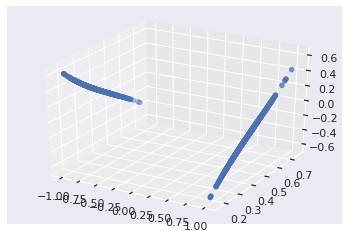

In [221]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()							
ax = fig.gca(projection='3d')
ax.scatter(bs_df.side,bs_df.p_rf, m_prob_rf)									

plt.show()

average

In [222]:
m_prob_avg_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_rf, num_classes=2, num_threads=3, average_active=True, pred=bs_df.side)
m_prob_avg_rf = m_prob_avg_rf.loc[bs_df.index]
m_prob_avg_rf

2020-02-01 14:47:24.945637 100.0% mp_avg_active_signals done after 0.07 minutes. Remaining 0.0 minutes.


2015-08-24 15:45:59    0.170978
2015-08-24 15:46:26    0.134035
2015-08-25 09:30:10    0.410743
2015-08-25 09:31:13    0.298403
2015-08-25 09:35:31    0.287409
                         ...   
2019-06-12 10:31:07    0.030259
2019-06-13 09:47:27    0.143231
2019-06-13 10:07:58    0.065080
2019-06-18 09:39:42    0.010867
2019-06-18 09:48:55    0.047727
Length: 918, dtype: float64

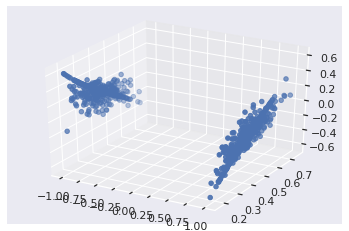

In [223]:
fig = plt.figure()							
ax = fig.gca(projection='3d')
ax.scatter(bs_df.side,bs_df.p_rf, m_prob_avg_rf)									

plt.show()

discrete

In [224]:
m_prob_discrete_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_rf, num_classes=2,pred=bs_df.side, num_threads=3, average_active=True, step_size=0.01)
m_prob_discrete_rf = m_prob_discrete_rf.loc[bs_df.index]
m_prob_discrete_rf

2020-02-01 14:47:29.248151 100.0% mp_avg_active_signals done after 0.06 minutes. Remaining 0.0 minutes.


2015-08-24 15:45:59    0.17
2015-08-24 15:46:26    0.13
2015-08-25 09:30:10    0.41
2015-08-25 09:31:13    0.30
2015-08-25 09:35:31    0.29
                       ... 
2019-06-12 10:31:07    0.03
2019-06-13 09:47:27    0.14
2019-06-13 10:07:58    0.07
2019-06-18 09:39:42    0.01
2019-06-18 09:48:55    0.05
Length: 918, dtype: float64

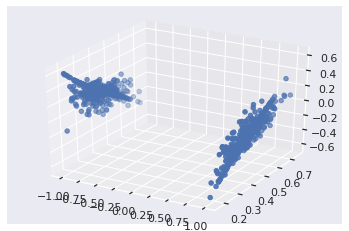

In [225]:
fig = plt.figure()							
ax = fig.gca(projection='3d')
ax.scatter(bs_df.side,bs_df.p_rf, m_prob_discrete_rf)									

plt.show()

In [0]:
bet_sizes_rf = pd.DataFrame({'m_rf':m_prob_rf,'m_avg_rf':m_prob_avg_rf,'m_dis_rf':m_prob_discrete_rf})
#bet_sizes_gbc = pd.DataFrame({'m_gb':m_prob_gbc,'m_avg_gb':m_prob_avg_gbc,'m_dis_gb':m_prob_discrete_gbc})

Text(0.5, 1.0, 'Bet Size 100 points')

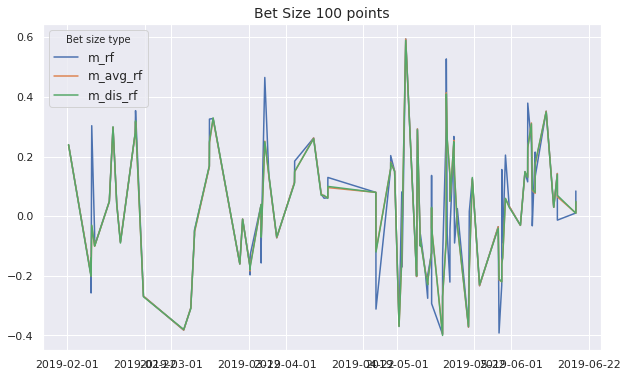

In [227]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(bet_sizes_rf[-100:])
ax.legend(labels=bet_sizes_rf.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution RF')

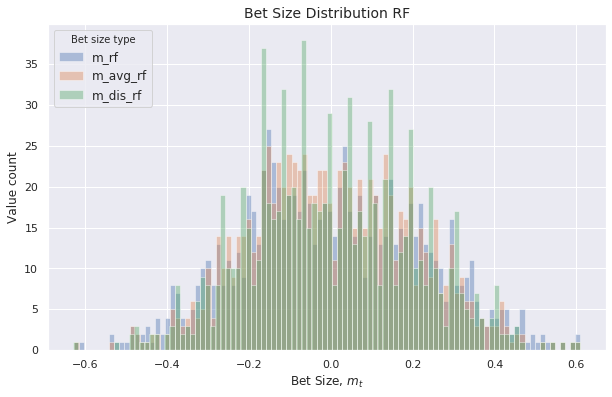

In [228]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['m_rf','m_avg_rf','m_dis_rf']:
    ax.hist(bet_sizes_rf[c],  label=c, alpha=0.4, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution RF", fontsize=14)

In [232]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=bs_df['t1'], sides=bs_df.side, return_parameters=True, fit_runs=25)
print(m_reserve[0])
print('Parameters are ',m_reserve[1])

|#########################| Completed 25 of 25 fitting rounds.

                                     t1  side  ...  c_t  bet_size
2015-08-24 15:45:59 2015-08-24 15:49:57  -1.0  ...   -1 -0.401315
2015-08-24 15:46:26 2015-08-24 15:58:26  -1.0  ...   -2 -0.732590
2015-08-25 09:30:10 2015-08-25 13:26:25  -1.0  ...   -1 -0.401315
2015-08-25 09:31:13 2015-08-25 15:47:22  -1.0  ...   -2 -0.732590
2015-08-25 09:35:31 2015-08-26 09:36:28  -1.0  ...   -3 -0.935450
...                                 ...   ...  ...  ...       ...
2019-06-12 10:31:07 2019-06-13 09:36:29   1.0  ...    1  0.356361
2019-06-13 09:47:27 2019-06-13 11:09:28  -1.0  ...   -1 -0.401315
2019-06-13 10:07:58 2019-06-14 10:08:37  -1.0  ...   -2 -0.732590
2019-06-18 09:39:42 2019-06-19 09:42:00  -1.0  ...   -1 -0.401315
2019-06-18 09:48:55 2019-06-19 09:54:13  -1.0  ...   -2 -0.732590

[918 rows x 6 columns]
Parameters are  {'mu_1': -1.86634, 'mu_2': 0.8581, 'sigma_1': 0.93868, 'sigma_2': 1.52161, 'p_1': 0.20301}


In [231]:
m_budget = bs.bet_sizing.bet_size_budget(bs_df.t1, bs_df.side)
m_budget

,t1,side,active_long,active_short,bet_size
2015-08-24 15:45:59,2015-08-24 15:49:57,-1.0,0,1,-0.200000
2015-08-24 15:46:26,2015-08-24 15:58:26,-1.0,0,2,-0.400000
2015-08-25 09:30:10,2015-08-25 13:26:25,-1.0,0,1,-0.200000
2015-08-25 09:31:13,2015-08-25 15:47:22,-1.0,0,2,-0.400000
2015-08-25 09:35:31,2015-08-26 09:36:28,-1.0,0,3,-0.600000
...,...,...,...,...,...
2019-06-12 10:31:07,2019-06-13 09:36:29,1.0,1,0,0.166667
2019-06-13 09:47:27,2019-06-13 11:09:28,-1.0,0,1,-0.200000
2019-06-13 10:07:58,2019-06-14 10:08:37,-1.0,0,2,-0.400000
2019-06-18 09:39:42,2019-06-19 09:42:00,-1.0,0,1,-0.200000


In [0]:
bet_sizes_others = pd.DataFrame({'mreserve':m_reserve[0].bet_size,'mbudget':m_budget.bet_size})

In [0]:
bet_sizes = pd.concat([bet_sizes_rf, bet_sizes_others], axis=1)
data_profit = bet_sizes.copy()
data_profit['NoSizeRF'] = (bs_df.side * bs_df.bin_pred_rf).loc[bet_sizes.index]
#data_profit['NoSizeGB'] = (bs_df.side * bs_df.bin_pred_gbc).loc[bet_sizes.index]
data_profit['primary'] = (bs_df.side * bs_df.bin).loc[bet_sizes.index]
data_profit['side'] = (bs_df.side).loc[bet_sizes.index]
data_profit['ret'] = bin.ret.loc[bet_sizes.index]


In [243]:
data_profit.columns

Index(['m_rf', 'm_avg_rf', 'm_dis_rf', 'mreserve', 'mbudget', 'NoSizeRF',
       'primary', 'side', 'ret'],
      dtype='object')

In [0]:
bet_profit = pd.DataFrame()
bet_profit['ProbRF'] = data_profit.m_rf * data_profit.ret
bet_profit['ProbAvgRF'] = data_profit.m_avg_rf * data_profit.ret
bet_profit['ProbDiscreteRF'] = data_profit.m_dis_rf * data_profit.ret
bet_profit['NoSizeRF'] = data_profit.NoSizeRF * data_profit.ret
bet_profit['PrimaryLabel'] = data_profit.primary * data_profit.ret
bet_profit['SidesOnly'] = data_profit.side * data_profit.ret
bet_profit['Reserve'] = data_profit.mreserve * data_profit.ret
bet_profit['Budget'] = data_profit.mbudget * data_profit.ret

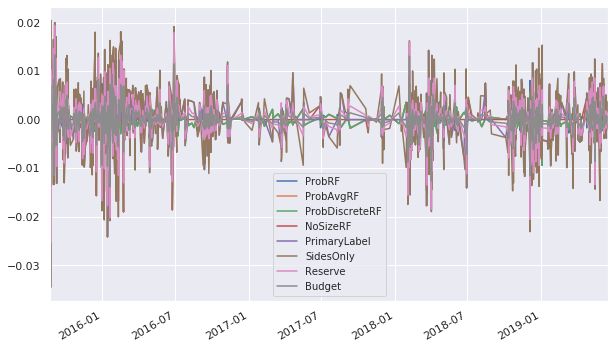

In [245]:
bet_profit.plot(figsize=(10,6))

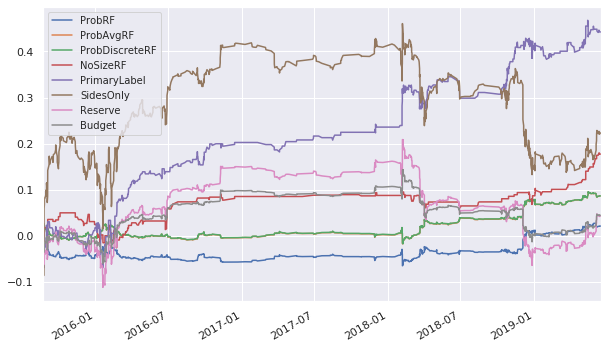

In [246]:
bet_profit.cumsum().plot(figsize=(10,6))

In [0]:
def sr(df):
    out = []
    for c in df.columns:
        out.append(df[c].mean()/df[c].std())
    i = np.argsort(out)
    return df.columns[i]

In [250]:
print(sr(bet_profit), '순으로 Sharpe Ratio가 낮음.')

Index(['Reserve', 'ProbRF', 'Budget', 'SidesOnly', 'ProbDiscreteRF',
       'ProbAvgRF', 'NoSizeRF', 'PrimaryLabel'],
      dtype='object') 순으로 Sharpe Ratio가 낮음.


# REFERENCE

Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley, 2018

https://github.com/hudson-and-thames/research

Marcos Lopez de Prado and Matthew D. Foreman. “A mixture of Gaussians approach to mathematical portfolio oversight: the EF3M algorithm”. In: Quantitative Finance14.5 (2014), pp. 913–930.

Yakup Kara
, Melek Acar Boyacioglu 
, Ömer Kaan Baykan. "Predicting direction of stock price index movement using artificial neural
networks and support vector machines: The sample of the Istanbul Stock Exchange"


https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities

s/o to mlfinlab, ta, pyfolio